In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\elmog\AppData\Local\Temp\ipykernel_41908\3517338504.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5],
        std =[0.5]
        # mean=[0.5,0.5,0.5],
        # std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [28]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.FashionMNIST(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)
test_data = torchvision.datasets.FashionMNIST(
                                root='./data', 
                                download=True, 
                                train=False, 
                                transform=transform)

In [29]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [30]:
# Step 3: Split the testset into test & dev
randidx = np.random.permutation(10000)
dev_data = Subset(test_data, randidx[:4000])
test_data = Subset(test_data, randidx[4000:])

In [31]:
# Step 4: Translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=batchsize)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [32]:
# Number of images in each dataset
print(len(train_data))
print(len(dev_data))
print(len(test_data))

60000
4000
6000


In [33]:
# range of pixel intensity values
print(train_data.data.min().item(), train_data.data.max().item())

0 255


In [34]:
# unique class categories
print(train_data.classes)
print(len(train_data.classes))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [35]:
# Check dimentions from train loader
# Therefore: transformations are ONLY applied when we pull data from train_loader
X, y = next(iter(train_loader))
print(X.data.shape)
# number of images * channels features * width * height

torch.Size([32, 1, 28, 28])


In [36]:
#check intesity from train loaders
# Therefore: transformations are ONLY applied when we pull data from train_loader
print(torch.min(X.data), torch.max(X.data))

tensor(-1.) tensor(1.)


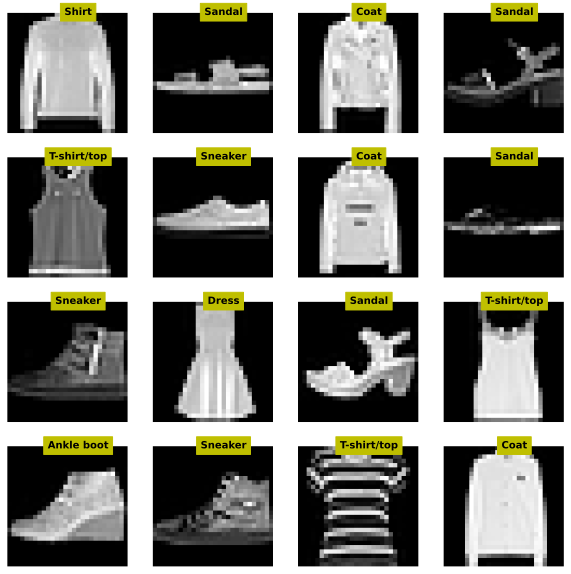

In [39]:
# check for a few random images
fix, axs = plt.subplots(4,4,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    
    #extract the image (transpose it back to 32x32x3) so matplot can understand it
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + 0.5 #undo normalization
    
    label = train_data.classes[y[i]]
    
    ax.imshow(pic, cmap='gray')
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

In [40]:
# parameters
#inChans  = 3 # RGB
#outChans = 15
#krnSize  = 5 # should be an odd number
#stride   = 1
#padding  = 0

#imsize   = [256,256]

## create the instance
#c = nn.Conv2d         (inChans,outChans,krnSize,stride,padding)
#c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# create an image
#img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
#resimg = c(img)
#empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
#expectSize = np.array([outChans,0,0],dtype=int)
#expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
#expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
#print(f'Expected size: {expectSize}')
#print(f'Empirical size: {list(empSize)}')

In [44]:
# **) size of transpose convolution formula "to calculate the image size of the transpose convolution"
# **) # of pixels in output image = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
# **)                       Nh    = Sh      * (Mh                         - 1) + K                               - 2*P
# #
# *) size of convolution formula "to calculate the image size of convolution"
# *) # of pixels in current layer = Floor ( (# of pixels in previous layer  + 2*Padding - # of pixels in kernel height) / Stride ) + 1
# *)                        Nh    = Floor ( ( Mh                            + 2*P       - K                           ) / Sh     ) + 1
# *) expectSize = np.array([outChans, 0, 0], dtype=int)
# *) expectsize[1] = np.floor( (imsize[0] + 2*padding - krnSize) / stride[0] ) + 1
# *) expectsize[2] = np.floor( (imsize[1] + 2*padding - krnSize) / s/tride[1] ) + 1
# #
# 1) Image (channels   X Width  X Height)
# 1) Image (1          X i/p 28 X i/p 28)
# #
# 2) Conv1 (# of feature maps kernels   X o/p Width X o/p Height)
# 2) Conv1 ( 10                         X 26        X 26        ) #lost 1 pixel left & 1 pixel right (1 pixel top & 1 pixel bottom) 
# #
# 3) maxpool1 (# of feature maps kernels X o/p width X o/p Height)
# 3) maxpool1 (10                        X 13        X 13        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 4) Conv2 (# of feature maps kernels   X o/p Width X o/p Height)
# 4) Conv2 (20                          X 11        X 11        )
# #
# 5) maxpool2 (# of feature maps kernels X o/p width X o/p Height)
# 5) maxpool2 (20                        X 5        X 5        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 6) ANN layer (1X50)

In [51]:
train_loader.dataset.data[0][0].shape

torch.Size([28])

In [119]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            imgSize = train_loader.dataset.data[0].shape[0] #28
            inChans  = 1 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 0 # square if single input
            stride   = 1 # use maxpool instead of stride ... so stride = 1
            
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv2d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm2d(outChans) # 64
            outputSize = np.floor( (imgSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (28 + 2*0 - 3) / 1 ) + 1 = 26
            # output size = 26/2 = 13 b/c of pool
            
            # Second Convolution Layer
            self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm2d(outChans*2) # 128
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (13 + 2*0 - 3) / 1 ) + 1 = 11
            # output size = 11/2 = 5 b/c of pool
            
            # Third Convolution Layer
            # self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding)
            # self.bnorm3 = nn.BatchNorm2d(outChans*2*2) # 256
            # output size = floor( (5 + 2*0 - 3) / 1 ) + 1 = 3
            # output size = 3/2 = 1 b/c of avgpool

            ### ------- Linear Layer ------- ###
            # self.fc1 = nn.Linear(flattened_size,200) #1024, 256
            flattened_size = (outputSize**2) * (outChans*2)
            # print(flattened_size)
            self.fc1 = nn.Linear(int(flattened_size),200) #1024, 256
            self.fc2 = nn.Linear(200,50)
            self.fc3 = nn.Linear(50,10)
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = F.max_pool2d( self.conv1(x), 2)
            x = F.leaky_relu( self.bnorm1(x)  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = F.max_pool2d( self.conv2(x), 2)
            x = F.leaky_relu( self.bnorm2(x)  )
            if self.print: print(f'Second conv: {list(x.shape)}')

            # x = F.max_pool2d( self.conv3(x), 2)
            # x = F.leaky_relu( self.bnorm3(x)  )
            # if self.print: print(f'Third conv: {list(x.shape)}')

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.leaky_relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
            
            x = F.leaky_relu( self.fc2(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc2: {list(x.shape)}')
            
            x = self.fc3(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001,
                                weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [120]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

X, y = next(iter(train_loader))

X = X.to(device)
y = y.to(device)

yHat = net2(X)

#check size of output
print(yHat.shape)

#compute the loss
loss = lossfun2(yHat, torch.squeeze(y))
print(loss)

3200.0
Input: [32, 1, 28, 28]
First conv: [32, 64, 13, 13]
Second conv: [32, 128, 5, 5]
Vectorized: [32, 3200]
fc1: [32, 200]
fc2: [32, 50]
Final Output: [32, 10]
torch.Size([32, 10])
tensor(2.2939, device='cuda:0', grad_fn=<NllLossBackward0>)


In [121]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=20):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    devLoss   = torch.zeros(numepochs)
    devAcc  = []

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            batchLoss.append(loss.item())
            
            # accuracy from this batch for categorical data
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            batchAcc.append( torch.mean(accMatchesNumeric).item() )

            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 0.5))
            
            #accuracy from this batch -> for BCE sigmoid
            # accMatches = torch.sigmoid(yHat) > 0.5 ##
            # accMatchesNumeric = accMatches.float()
            # batchAcc.append( torch.mean( (accMatchesNumeric == y).float() ).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((batchAcc)))
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(batchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()

        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        #final forward pass for Test Accuracy
        # X,y = next(iter(dev_loader))
        for X, y in dev_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            batchLoss.append(loss.item())
            
            #batch acc
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            batchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        devLoss[epochi] = ( np.mean(batchLoss) )
        
        devAcc.append(100*np.mean(batchAcc))

        # testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        # testMatchesNumeric = (testMatches < 1)
        # testAcc.append(100 * np.mean( testMatchesNumeric ) )

        #compute the test accuracy for BCE sigmoid
        # testMatches = torch.sigmoid(yHat) > 0.5 
        # testMatchesNumeric = testMatches.float()
        # testAcc.append(100 * torch.mean( (testMatchesNumeric == y).float() ).item() )
    
    # return losses, trainedModel
    # return trainAcc, losses, trainedModel
    return trainAcc, trainLoss, devAcc, devLoss, trainedModel

In [122]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet()
# losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc2, losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
trainAcc2, trainLoss2, devAcc2, devLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

3200.0


In [123]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, devAcc, devLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, testAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

3200.0


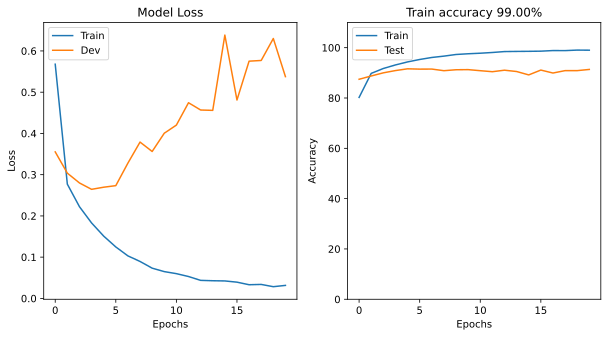

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
ax[0].plot(devLoss, label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(devAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])

plt.show()

In [125]:
# run the real test set
trainedModel.eval()
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

#forward pass & loss
with torch.no_grad():
    yHat = trainedModel(X)
    loss = lossfun(yHat, y)
    
testLoss = loss.item()
    
testAccMatches = torch.argmax(yHat, axis=1)
testAccMatchesNumeric = (testAccMatches == y).float()
testAcc = ( 100 * torch.mean(testAccMatchesNumeric) ).item()


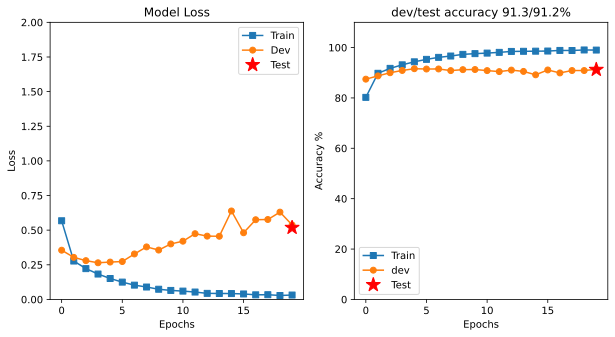

In [126]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, 's-' , label='Train')
ax[0].plot(devLoss,   'o-' ,label='Dev')
ax[0].plot(len(devLoss)-1, testLoss, 'r*', markersize=15, label='Test')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylim([0,2])



ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(devAcc,   'o-', label='dev')
ax[1].plot(len(devAcc)-1, testAcc, 'r*', markersize=15, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'dev/test accuracy {devAcc[-1]:0.1f}/{testAcc:0.1f}%')
ax[1].set_ylim([0,110])

plt.show()

In [127]:
devLoss

tensor([0.3552, 0.3037, 0.2799, 0.2645, 0.2696, 0.2734, 0.3281, 0.3790, 0.3562,
        0.4005, 0.4203, 0.4744, 0.4568, 0.4559, 0.6384, 0.4811, 0.5752, 0.5769,
        0.6302, 0.5377])

In [128]:
trainLoss

tensor([0.5678, 0.2770, 0.2224, 0.1830, 0.1510, 0.1247, 0.1030, 0.0895, 0.0733,
        0.0650, 0.0600, 0.0531, 0.0437, 0.0428, 0.0423, 0.0394, 0.0331, 0.0339,
        0.0284, 0.0315])

In [129]:
testLoss

0.5182317495346069